## Data Loader

In [3]:
"""
modified from https://github.com/mlmed/torchxrayvision/blob/master/torchxrayvision/datasets.py
"""
from pathlib import Path
from tqdm import tqdm

# from toolz import *
# from toolz.curried import *
# from toolz.curried.operator import *

import pandas as pd

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader


class MimicDataset(Dataset):

    split_ratio = [0.6, 0.2, 0.2]

    embed_prefix = "embds"

    pathologies = ["Enlarged Cardiomediastinum",
                   "Cardiomegaly",
                   "Lung Opacity",
                   "Lung Lesion",
                   "Edema",
                   "Consolidation",
                   "Pneumonia",
                   "Atelectasis",
                   "Pneumothorax",
                   "Pleural Effusion",
                   "Pleural Other",
                   "Fracture",
                   "Support Devices"]


    embedding_d = {
        "BiomedCLIP": Path("~/fsx/embeddings/MIMIC/embds_BiomedCLIP"), 
        "CheXagent": Path("~/fsx/embeddings/MIMIC/embds_CheXagent"), 
        "MedGemma": Path("~/fsx/embeddings/MIMIC/embds_MedGemma"),
        "RAD-DINO": Path("~/fsx/embeddings/MIMIC/embds_RAD-DINO"),
    }

    csvpath = Path("~/fsx/embeddings/MIMIC/Tables/mimic-cxr-2.0.0-chexpert.csv")
    metacsvpath = Path("~/fsx/embeddings/MIMIC/Tables/mimic-cxr-2.0.0-metadata.csv")
    base_dicom_path = Path("/home/jupyter-oluwatunmise/fsx/embeddings/MIMIC/")

    def __init__(
        self,
        views: str = ["PA", "AP"][0],
        mode: str = ["train", "validate", "test"][0],
        embedding_type: str = ["BiomedCLIP", "CheXagent", "MedGemma", "RAD-DINO", "All"][0],       
        unique_patients=True,
        seed : int = 0):
        
        np.random.seed(seed)  # Reset the seed so all runs are the same.        
        self.views = views
        self.mode = mode
        self.embedding_type = embedding_type
        self.unique_patients = unique_patients        
        self.seed = seed
        
        self.embpath: str | list[str] = self.load_emb_path(embedding_type)
            
        self.csv = pd.read_csv(self.csvpath)
        self.metacsv = pd.read_csv(self.metacsvpath)
        self.csv = self.csv.set_index(["subject_id", "study_id"])
        self.metacsv = self.metacsv.set_index(["subject_id", "study_id"])
        self.csv = self.csv.join(self.metacsv).reset_index()        

        # Keep only the desired view
        self.csv["view"] = self.csv["ViewPosition"]
        self.limit_to_selected_views(views)
    
        if unique_patients:
            self.csv = self.csv.groupby("subject_id").first().reset_index()

        self.csv = self.csv.sample(frac=1, random_state=self.seed).reset_index(drop=True)
        self.csv = self.csv.fillna(0)
        
        n_row = self.csv.shape[0]
        
        # spit data to one of train valid test
        if self.mode == "train":
            self.csv = self.csv[: int(n_row * self.split_ratio[0])]
        elif self.mode == "valid":
            self.csv = self.csv[
                int(n_row * self.split_ratio[0]) : int(
                    n_row * (self.split_ratio[0] + self.split_ratio[1])
                )
            ]            
        elif self.mode == "test":
            self.csv = self.csv[-int(n_row * self.split_ratio[-1]) :]
        else:
            raise ValueError(
                f"attr:mode has to be one of [train, valid, test] but your input is {self.mode}"
            )

        # Get our classes.
        healthy = self.csv["No Finding"] == 1
        labels = []
        for pathology in self.pathologies:
            if pathology in self.csv.columns:
                self.csv.loc[healthy, pathology] = 0
                mask = self.csv[pathology]

            labels.append(mask.values)
        self.labels = np.asarray(labels).T
        self.labels = self.labels.astype(np.float32)

        # Make all the -1 values into nans to keep things simple
        self.labels[self.labels == -1] = 0

        # Rename pathologies
        self.pathologies = list(np.char.replace(self.pathologies, "Pleural Effusion", "Effusion"))
        # add consistent csv values

        # offset_day_int
        self.csv["offset_day_int"] = self.csv["StudyDate"]

        # patientid
        self.csv["patient_id"] = self.csv["subject_id"].astype(str)

    def __getitem__(self, i):        
        sample = {}
        sample["patient_id"] = int(self.csv.iloc[i]["patient_id"])
        sample["study_id"] = int(self.csv.iloc[i]["study_id"])
        sample["lab"] = self.labels[i]
        sample["emb"] = self.load_embedding(self.csv.iloc[i]["dicom_id"])

        return sample

    def __len__(self):
        return len(self.labels)        
        

    def load_emb_path(self, embedding_type):
        if self.embedding_type != "All":
            return self.embedding_d[embedding_type]
        else:            
            return list(self.embedding_d.values())

    def limit_to_selected_views(self, views):
        """This function is called by subclasses to filter the
        images by view based on the values in .csv['view']
        """
        if type(views) is not list:
            views = [views]
        if '*' in views:
            # if you have the wildcard, the rest are irrelevant
            views = ["*"]
        self.views = views

        # missing data is unknown
        self.csv.view.fillna("UNKNOWN", inplace=True)

        if "*" not in views:
            self.csv = self.csv[self.csv["view"].isin(self.views)]  # Select the view
    
    def load_embedding(self, embedding_id):
        if self.embedding_type == "All":
            merged_emb = []
            for embedding_type in range(self.embedding_d.keys()):
                emb = np.load(f"{self.base_dicom_path/('embds_'+ embedding_type)/embedding_id}.npy")
                merged_emb.append(emb)
            return np.concat(merged_emb)                
        else:
            return np.load(f"{self.base_dicom_path/('embds_'+ self.embedding_type)/embedding_id}.npy")
            
    def load_all(self):
        print(f"loading all {self.mode} data")
        samples = []
        for i in tqdm(range(self.__len__())):
            sample = self.__getitem__(i)
            samples.append(sample)
        return samples

class NSWDataLoader(DataLoader):
    def __init__(
        self,
        dataset,
        batch_size=1,
        shuffle=False,
        sampler=None,
        batch_sampler=None,
        num_workers=8,
        collate_fn=None,
        pin_memory=True,
        drop_last=False,
        timeout=0,
        worker_init_fn=None,
        multiprocessing_context=None,
        generator=None,
        prefetch_factor=None,
        persistent_workers=False,
        **kwargs
    ):

        # Initialize the parent class with all arguments
        super().__init__(
            dataset=dataset,
            batch_size=batch_size,
            shuffle=shuffle,
            sampler=sampler,
            batch_sampler=batch_sampler,
            num_workers=num_workers,
            collate_fn=collate_fn,
            pin_memory=pin_memory,
            drop_last=drop_last,
            timeout=timeout,
            worker_init_fn=worker_init_fn,
            multiprocessing_context=multiprocessing_context,
            generator=generator,
            prefetch_factor=prefetch_factor,
            persistent_workers=persistent_workers,
            **kwargs
        )


## Retrieving FMs into Dictionary

In [3]:
import numpy as np, pandas as pd, random, matplotlib.pyplot as plt, seaborn as sns
from typing import List, Dict, Tuple

# --- If you ALREADY built lists like biomedclip_train_dataset, we’ll use them.
# Otherwise we’ll construct them from MimicDataset on the fly.
FMS = ["BiomedCLIP", "CheXagent", "MedGemma", "RAD-DINO"]

def build_split(views, mode, embedding_type, unique_patients=True, seed=0):
    return MimicDataset(
        views=views, mode=mode, embedding_type=embedding_type,
        unique_patients=unique_patients, seed=seed
    ).load_all()

def get_or_build_split(name: str, fm: str):
    # name ∈ {"train","valid","test"}; pick from existing variables if present
    # Your variables were lowercase: biomedclip_train_dataset, etc.
    var_map = {
        ("BiomedCLIP","train"): "biomedclip_train_dataset",
        ("BiomedCLIP","valid"): "biomedclip_valid_dataset",
        ("BiomedCLIP","test"):  "biomedclip_test_dataset",
        ("CheXagent","train"):  "chexagent_train_dataset",
        ("CheXagent","valid"):  "chexagent_valid_dataset",
        ("CheXagent","test"):   "chexagent_test_dataset",
        ("MedGemma","train"):   "medgemma_train_dataset",
        ("MedGemma","valid"):   "medgemma_valid_dataset",
        ("MedGemma","test"):    "medgemma_test_dataset",
        ("RAD-DINO","train"):   "raddino_train_dataset",
        ("RAD-DINO","valid"):   "raddino_valid_dataset",
        ("RAD-DINO","test"):    "raddino_test_dataset",
    }
    varname = var_map.get((fm, name))
    g = globals()
    if varname in g:
        return g[varname]
    # else build
    return build_split("PA", name if name != "valid" else "valid", fm, True, 0)

splits = {"train": {}, "valid": {}, "test": {}}
for fm in FMS:
    splits["train"][fm] = get_or_build_split("train", fm)
    splits["valid"][fm] = get_or_build_split("valid", fm)
    splits["test"][fm]  = get_or_build_split("test", fm)


/tmp/ipykernel_101521/132785486.py:157: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  self.csv.view.fillna("UNKNOWN", inplace=True)


loading all train data


100%|██████████| 27376/27376 [02:05<00:00, 218.52it/s]
/tmp/ipykernel_101521/132785486.py:157: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  self.csv.view.fillna("UNKNOWN", inplace=True)


loading all valid data


100%|██████████| 9126/9126 [00:44<00:00, 203.68it/s]
/tmp/ipykernel_101521/132785486.py:157: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  self.csv.view.fillna("UNKNOWN", inplace=True)


loading all test data


100%|██████████| 9125/9125 [00:42<00:00, 213.14it/s]
/tmp/ipykernel_101521/132785486.py:157: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  self.csv.view.fillna("UNKNOWN", inplace=True)


loading all train data


100%|██████████| 27376/27376 [02:14<00:00, 203.37it/s]
/tmp/ipykernel_101521/132785486.py:157: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  self.csv.view.fillna("UNKNOWN", inplace=True)


loading all valid data


100%|██████████| 9126/9126 [00:44<00:00, 206.56it/s]
/tmp/ipykernel_101521/132785486.py:157: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  self.csv.view.fillna("UNKNOWN", inplace=True)


loading all test data


100%|██████████| 9125/9125 [00:27<00:00, 330.71it/s]
/tmp/ipykernel_101521/132785486.py:157: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  self.csv.view.fillna("UNKNOWN", inplace=True)


loading all train data


100%|██████████| 27376/27376 [01:56<00:00, 235.78it/s]
/tmp/ipykernel_101521/132785486.py:157: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  self.csv.view.fillna("UNKNOWN", inplace=True)


loading all valid data


100%|██████████| 9126/9126 [00:44<00:00, 203.75it/s]
/tmp/ipykernel_101521/132785486.py:157: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  self.csv.view.fillna("UNKNOWN", inplace=True)


loading all test data


100%|██████████| 9125/9125 [00:44<00:00, 206.16it/s]
/tmp/ipykernel_101521/132785486.py:157: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  self.csv.view.fillna("UNKNOWN", inplace=True)


loading all train data


100%|██████████| 27376/27376 [02:13<00:00, 204.35it/s]
/tmp/ipykernel_101521/132785486.py:157: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  self.csv.view.fillna("UNKNOWN", inplace=True)


loading all valid data


100%|██████████| 9126/9126 [00:45<00:00, 202.02it/s]
/tmp/ipykernel_101521/132785486.py:157: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  self.csv.view.fillna("UNKNOWN", inplace=True)


loading all test data


100%|██████████| 9125/9125 [00:42<00:00, 213.82it/s]


## Concatenate embeddings across 4 FMs

In [4]:
# ===== Labels (after renaming Pleural Effusion -> Effusion) =====
label_cols = [
    "Enlarged Cardiomediastinum","Cardiomegaly","Lung Opacity","Lung Lesion","Edema",
    "Consolidation","Pneumonia","Atelectasis","Pneumothorax","Effusion",
    "Pleural Other","Fracture","Support Devices"
]

# ===== Helpers to align by patient_id and concat embeddings =====
from typing import List, Dict

def index_by_key(samples: List[Dict], key="patient_id") -> Dict[int, Dict]:
    d = {}
    for s in samples:
        d[int(s[key])] = s
    return d

def intersect_ids(dicts: List[Dict[int, Dict]]) -> List[int]:
    common = None
    for d in dicts:
        ids = set(d.keys())
        common = ids if common is None else (common & ids)
        if not common:
            break
    return sorted(list(common)) if common else []

def concat_features_across_fms(fm_to_samples: Dict[str, List[Dict]],
                               id_key="patient_id") -> List[Dict]:
    """
    Align by id_key across all FMs present; concatenate 'emb' vectors; take 'lab' from the first FM.
    Returns a list of samples with keys: patient_id, case_id, lab, emb
    """
    if not fm_to_samples:
        return []

    fm_dicts = {fm: index_by_key(samps, id_key) for fm, samps in fm_to_samples.items()}
    common = intersect_ids(list(fm_dicts.values()))
    out = []
    for pid in common:
        embs, lab = [], None
        for fm in fm_dicts:
            s = fm_dicts[fm][pid]
            e = np.asarray(s["emb"])
            if e.ndim > 1:
                e = e.reshape(-1)
            embs.append(e.astype(np.float32))
            if lab is None:
                lab = np.asarray(s["lab"], dtype=np.float32)
        out.append({
            "patient_id": int(pid),
            "case_id": int(pid),
            "lab": (lab > 0.5).astype(np.int32),
            "emb": np.concatenate(embs, axis=0)
        })
    return out

# ===== Build concatenated splits (aligned across all FMs you loaded) =====
concat_splits = {}
for split in ["train", "valid", "test"]:
    concat_splits[split] = concat_features_across_fms(splits[split])
    print(f"[Concat {split}] kept {len(concat_splits[split])} patients "
          f"(intersection across {len(splits[split])} FMs)")

[Concat train] kept 27376 patients (intersection across 4 FMs)
[Concat valid] kept 9126 patients (intersection across 4 FMs)
[Concat test] kept 9125 patients (intersection across 4 FMs)


## Run PCA on Concat

[Concat-PCA-16] TEST AUROC_macro=0.8336 | AP_macro=0.2269 | AUROC_micro=0.8484 | AP_micro=0.2338
[Concat-PCA-32] TEST AUROC_macro=0.8383 | AP_macro=0.2248 | AUROC_micro=0.8598 | AP_micro=0.2232
[Concat-PCA-64] TEST AUROC_macro=0.8469 | AP_macro=0.2317 | AUROC_micro=0.8758 | AP_micro=0.2656
[Concat-PCA-128] TEST AUROC_macro=0.8528 | AP_macro=0.2505 | AUROC_micro=0.8775 | AP_micro=0.2783
[Concat-PCA-256] TEST AUROC_macro=0.8476 | AP_macro=0.2501 | AUROC_micro=0.8699 | AP_micro=0.2630
[Concat-PCA-512] TEST AUROC_macro=0.8551 | AP_macro=0.2464 | AUROC_micro=0.8601 | AP_micro=0.2252
[Concat-PCA-1024] TEST AUROC_macro=0.8587 | AP_macro=0.2534 | AUROC_micro=0.8719 | AP_micro=0.2744


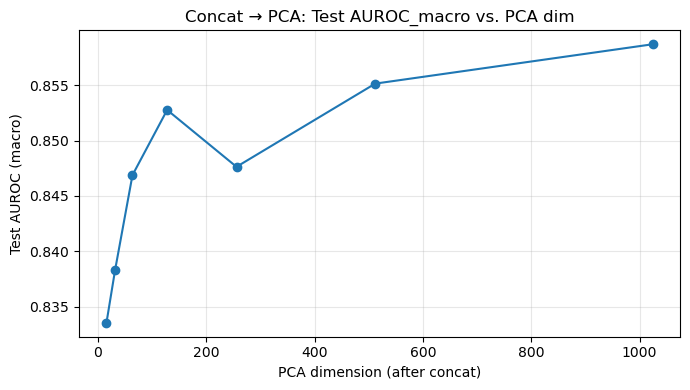

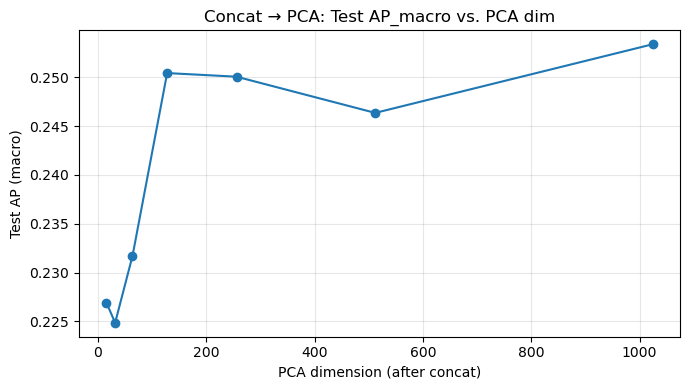

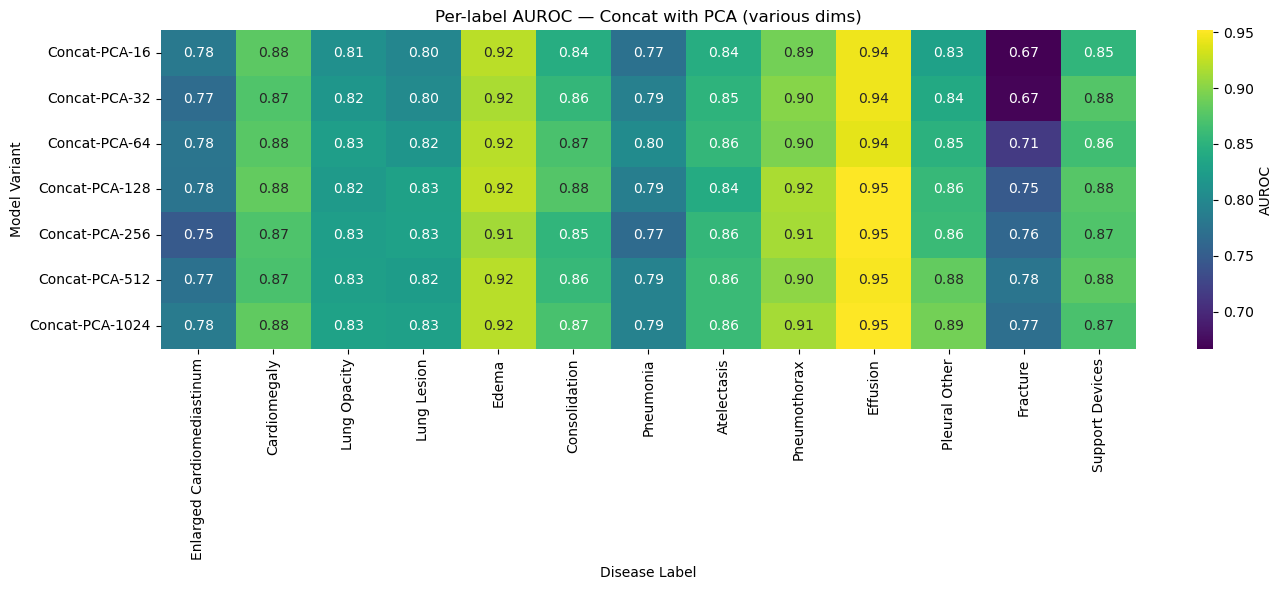

In [5]:
# ===== PCA-enabled trainer + safe PCA sweep + visuals =====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from typing import List, Dict, Tuple
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.decomposition import PCA

# ---------- utilities ----------
def stack_from_samples(samples: List[Dict]) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    if len(samples) == 0:
        raise ValueError("Empty sample list.")
    X_list, Y_list, ids = [], [], []
    for s in samples:
        emb = np.asarray(s["emb"])
        if emb.ndim > 1: emb = emb.reshape(-1)
        X_list.append(emb.astype(np.float32))
        Y_list.append(np.asarray(s["lab"], dtype=np.float32))
        ids.append(int(s["patient_id"]))
    X = np.vstack(X_list)
    Y = np.vstack(Y_list)
    ids = np.asarray(ids)
    X = np.nan_to_num(X, posinf=0.0, neginf=0.0)
    Y = np.nan_to_num(Y, posinf=0.0, neginf=0.0)
    Y = (Y > 0.5).astype(int)
    return X, Y, ids

# ---------- trainer with optional PCA ----------
def fit_eval_mlp_on_splits(
    train_samples: List[Dict],
    valid_samples: List[Dict],
    test_samples:  List[Dict],
    label_names: List[str],
    seed: int = 0,
    hidden=(512, 256),
    max_iter=120,
    pca_dim: int | None = None,   # NEW
    pca_whiten: bool = False,     # optional
) -> Dict[str, Dict[str, float]]:
    X_tr, Y_tr, _ = stack_from_samples(train_samples)
    X_va, Y_va, _ = stack_from_samples(valid_samples)
    X_te, Y_te, _ = stack_from_samples(test_samples)

    # scale using TRAIN only
    scaler = StandardScaler()
    X_tr_s = scaler.fit_transform(X_tr)
    X_va_s = scaler.transform(X_va)
    X_te_s = scaler.transform(X_te)

    # PCA after concat (optional)
    if pca_dim is not None and 0 < pca_dim < X_tr_s.shape[1]:
        pca = PCA(n_components=pca_dim, whiten=pca_whiten, random_state=seed)
        X_tr_s = pca.fit_transform(X_tr_s)
        X_va_s = pca.transform(X_va_s)
        X_te_s = pca.transform(X_te_s)

    L = Y_tr.shape[1]
    P_va = np.zeros((X_va_s.shape[0], L), dtype=float)
    P_te = np.zeros((X_te_s.shape[0], L), dtype=float)

    for j in range(L):
        y_tr = Y_tr[:, j]
        if len(np.unique(y_tr)) < 2:
            const_p = float(y_tr.mean())
            P_va[:, j] = const_p
            P_te[:, j] = const_p
            continue

        sw = compute_sample_weight("balanced", y_tr)
        clf = MLPClassifier(
            hidden_layer_sizes=hidden,
            activation="relu",
            solver="adam",
            alpha=1e-4,
            learning_rate_init=1e-3,
            batch_size=256,
            max_iter=max_iter,
            early_stopping=True,
            n_iter_no_change=10,
            validation_fraction=0.15,
            shuffle=True,
            random_state=seed,
        )
        clf.fit(X_tr_s, y_tr, sample_weight=sw)
        P_va[:, j] = clf.predict_proba(X_va_s)[:, 1]
        P_te[:, j] = clf.predict_proba(X_te_s)[:, 1]

    def split_metrics(Y_true: np.ndarray, P: np.ndarray) -> Dict[str, float]:
        per_auc, per_ap, valid_cols = {}, {}, []
        for j, lab in enumerate(label_names):
            yt = Y_true[:, j]
            if len(np.unique(yt)) < 2:
                per_auc[lab] = np.nan
                per_ap[lab]  = np.nan
            else:
                per_auc[lab] = roc_auc_score(yt, P[:, j])
                per_ap[lab]  = average_precision_score(yt, P[:, j])
                valid_cols.append(j)
        auroc_macro = float(np.nanmean(list(per_auc.values()))) if per_auc else np.nan
        ap_macro    = float(np.nanmean(list(per_ap.values())))  if per_ap else np.nan
        if valid_cols:
            auroc_micro = roc_auc_score(Y_true[:, valid_cols], P[:, valid_cols], average="micro")
            ap_micro    = average_precision_score(Y_true[:, valid_cols], P[:, valid_cols], average="micro")
        else:
            auroc_micro = np.nan; ap_micro = np.nan
        return dict(
            AUROC_macro=auroc_macro, AP_macro=ap_macro,
            AUROC_micro=auroc_micro, AP_micro=ap_micro,
            per_label_AUROC=per_auc, per_label_AP=per_ap,
        )

    return {"valid": split_metrics(Y_va, P_va), "test": split_metrics(Y_te, P_te)}

# ---------- SAFE PCA sweep over concatenated splits ----------
# expects: concat_splits["train"|"valid"|"test"] and label_cols already defined
X_tr_concat, _, _ = stack_from_samples(concat_splits["train"])
full_dim = X_tr_concat.shape[1]

# candidate dims; keep valid (< full_dim)
pca_dims = [16, 32, 64, 128, 256, 512, 1024]
pca_dims = [d for d in pca_dims if d < full_dim]
if len(pca_dims) == 0:
    print(f"No PCA dims < concatenated dim ({full_dim}). Skipping PCA sweep.")

concat_grid_results: Dict[str, Dict[str, Dict[str, float]]] = {}
concat_grid_perlabel: Dict[str, Dict[str, float]] = {}

for d in pca_dims:
    tag = f"Concat-PCA-{d}"
    try:
        res_d = fit_eval_mlp_on_splits(
            train_samples=concat_splits["train"],
            valid_samples=concat_splits["valid"],
            test_samples=concat_splits["test"],
            label_names=label_cols,
            seed=0, hidden=(512,256), max_iter=120,
            pca_dim=d,  # PCA after concat
            # pca_whiten=True,  # optional
        )
        concat_grid_results[tag] = {
            "valid": {k:v for k,v in res_d["valid"].items() if not isinstance(v, dict)},
            "test":  {k:v for k,v in res_d["test"].items()  if not isinstance(v, dict)},
        }
        concat_grid_perlabel[tag] = res_d["test"]["per_label_AUROC"]
        print(f"[{tag}] TEST AUROC_macro={concat_grid_results[tag]['test']['AUROC_macro']:.4f} "
              f"| AP_macro={concat_grid_results[tag]['test']['AP_macro']:.4f} "
              f"| AUROC_micro={concat_grid_results[tag]['test']['AUROC_micro']:.4f} "
              f"| AP_micro={concat_grid_results[tag]['test']['AP_micro']:.4f}")
    except Exception as e:
        print(f"⚠️ Skipping {tag} due to error: {e}")

[Concat-PCA-4] TEST AUROC_macro=0.8245 | AP_macro=0.1957 | AUROC_micro=0.8413 | AP_micro=0.1924
[Concat-PCA-8] TEST AUROC_macro=0.8343 | AP_macro=0.2236 | AUROC_micro=0.8551 | AP_micro=0.2192


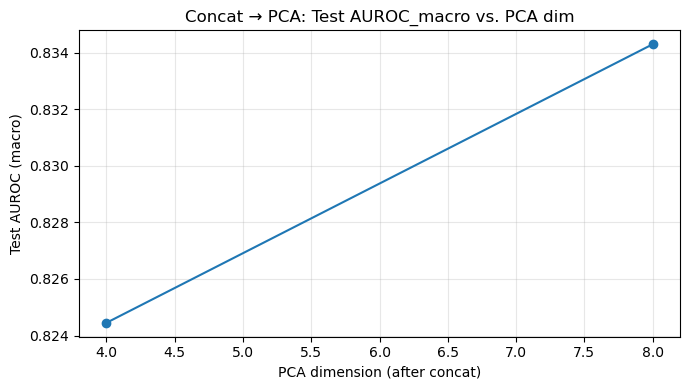

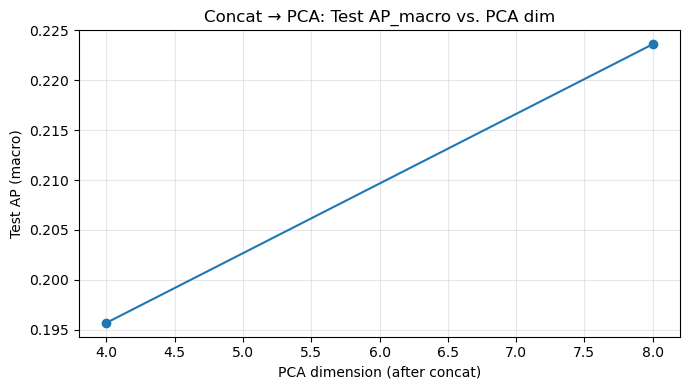

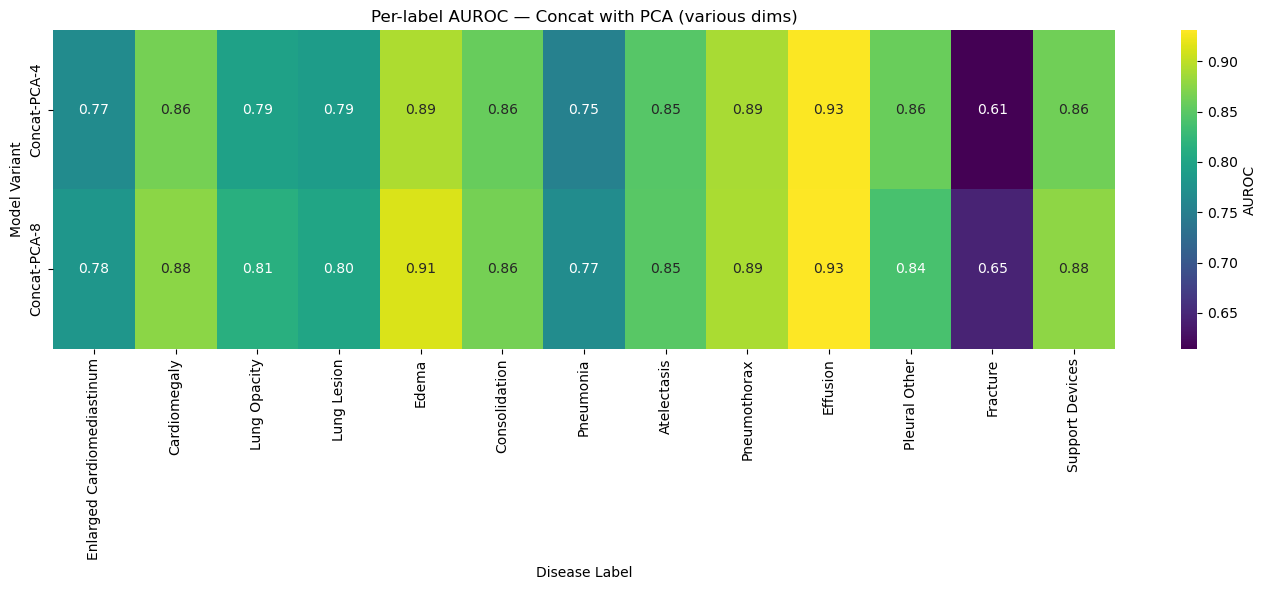

In [12]:
# ---------- SAFE PCA sweep over concatenated splits ----------
# expects: concat_splits["train"|"valid"|"test"] and label_cols already defined
X_tr_concat, _, _ = stack_from_samples(concat_splits["train"])
full_dim = X_tr_concat.shape[1]

# candidate dims; keep valid (< full_dim)
pca_dims = [4, 8]
pca_dims = [d for d in pca_dims if d < full_dim]
if len(pca_dims) == 0:
    print(f"No PCA dims < concatenated dim ({full_dim}). Skipping PCA sweep.")

concat_grid_results: Dict[str, Dict[str, Dict[str, float]]] = {}
concat_grid_perlabel: Dict[str, Dict[str, float]] = {}

for d in pca_dims:
    tag = f"Concat-PCA-{d}"
    try:
        res_d = fit_eval_mlp_on_splits(
            train_samples=concat_splits["train"],
            valid_samples=concat_splits["valid"],
            test_samples=concat_splits["test"],
            label_names=label_cols,
            seed=0, hidden=(512,256), max_iter=120,
            pca_dim=d,  # PCA after concat
            # pca_whiten=True,  # optional
        )
        concat_grid_results[tag] = {
            "valid": {k:v for k,v in res_d["valid"].items() if not isinstance(v, dict)},
            "test":  {k:v for k,v in res_d["test"].items()  if not isinstance(v, dict)},
        }
        concat_grid_perlabel[tag] = res_d["test"]["per_label_AUROC"]
        print(f"[{tag}] TEST AUROC_macro={concat_grid_results[tag]['test']['AUROC_macro']:.4f} "
              f"| AP_macro={concat_grid_results[tag]['test']['AP_macro']:.4f} "
              f"| AUROC_micro={concat_grid_results[tag]['test']['AUROC_micro']:.4f} "
              f"| AP_micro={concat_grid_results[tag]['test']['AP_micro']:.4f}")
    except Exception as e:
        print(f"⚠️ Skipping {tag} due to error: {e}")

# ---------- Plot: macro metrics vs PCA dim (robust to missing dims) ----------
rows = []
for d in pca_dims:
    tag = f"Concat-PCA-{d}"
    if tag not in concat_grid_results:
        print(f"⚠️ Skipping {tag} (no results)")
        continue
    rows.append({
        "pca_dim": d,
        "AUROC_macro": concat_grid_results[tag]["test"]["AUROC_macro"],
        "AP_macro":    concat_grid_results[tag]["test"]["AP_macro"],
        "AUROC_micro": concat_grid_results[tag]["test"]["AUROC_micro"],
        "AP_micro":    concat_grid_results[tag]["test"]["AP_micro"],
    })
df_pca = pd.DataFrame(rows).sort_values("pca_dim")

if not df_pca.empty:
    plt.figure(figsize=(7,4))
    plt.plot(df_pca["pca_dim"], df_pca["AUROC_macro"], marker="o")
    plt.xlabel("PCA dimension (after concat)")
    plt.ylabel("Test AUROC (macro)")
    plt.title("Concat → PCA: Test AUROC_macro vs. PCA dim")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(7,4))
    plt.plot(df_pca["pca_dim"], df_pca["AP_macro"], marker="o")
    plt.xlabel("PCA dimension (after concat)")
    plt.ylabel("Test AP (macro)")
    plt.title("Concat → PCA: Test AP_macro vs. PCA dim")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("No PCA points to plot.")

# ---------- Optional: per-label heatmap over PCA variants ----------
def plot_per_label_heatmap(per_label_results: Dict[str, Dict[str, float]],
                           label_cols: List[str],
                           title="Per-label AUROC: Concat + PCA sweep"):
    df_scores = pd.DataFrame(per_label_results).T
    for c in label_cols:
        if c not in df_scores.columns:
            df_scores[c] = np.nan
    df_scores = df_scores[label_cols]
    plt.figure(figsize=(14, 6))
    sns.heatmap(df_scores, annot=True, fmt=".2f", cmap="viridis",
                cbar_kws={'label':'AUROC'})
    plt.title(title)
    plt.xlabel("Disease Label")
    plt.ylabel("Model Variant")
    plt.tight_layout()
    plt.show()

if len(concat_grid_perlabel):
    plot_per_label_heatmap(concat_grid_perlabel, label_cols,
                           title="Per-label AUROC — Concat with PCA (various dims)")

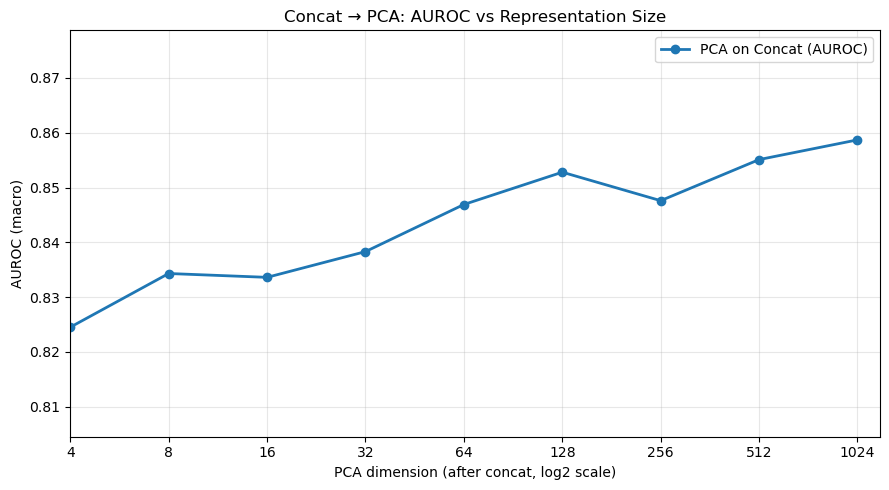

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# ==== Your results ====
results_small = {
    4:  {"AUROC_macro": 0.8245, "AP_macro": 0.1957},
    8:  {"AUROC_macro": 0.8343, "AP_macro": 0.2236},
}
results_large = {
    16:  {"AUROC_macro": 0.8336, "AP_macro": 0.2269},
    32:  {"AUROC_macro": 0.8383, "AP_macro": 0.2248},
    64:  {"AUROC_macro": 0.8469, "AP_macro": 0.2317},
    128: {"AUROC_macro": 0.8528, "AP_macro": 0.2505},
    256: {"AUROC_macro": 0.8476, "AP_macro": 0.2501},
    512: {"AUROC_macro": 0.8551, "AP_macro": 0.2464},
    1024:{"AUROC_macro": 0.8587, "AP_macro": 0.2534},
}

# Merge -> DataFrame
all_results = {**results_small, **results_large}
df_pca = pd.DataFrame(all_results).T
df_pca.index.name = "pca_dim"
df_pca = df_pca.reset_index().sort_values("pca_dim")

# ==== AUROC-only plot (log2 x-axis) ====
plt.figure(figsize=(9,5))
plt.plot(df_pca["pca_dim"], df_pca["AUROC_macro"], marker="o", linewidth=2, label="PCA on Concat (AUROC)")

# Make small dims readable
dims = df_pca["pca_dim"].tolist()
plt.xscale("log", base=2)
plt.xticks(dims, labels=dims)
plt.xlim(min(dims), 1200)

plt.xlabel("PCA dimension (after concat, log2 scale)")
plt.ylabel("AUROC (macro)")
plt.title("Concat → PCA: AUROC vs Representation Size")
plt.grid(True, which="both", alpha=0.3)
plt.ylim(max(0.0, df_pca["AUROC_macro"].min() - 0.02),
         min(1.0, df_pca["AUROC_macro"].max() + 0.02))
plt.legend()
plt.tight_layout()
plt.show()

In [2]:
# === Manually type in your results ===
# Replace the {...} with your per-label AUROC values for each PCA dim

concat_grid_perlabel_small = {
    "Concat-PCA-4": {
        "Enlarged Cardiomediastinum": 0.77,
        "Cardiomegaly": 0.86,
        "Lung Opacity": 0.79,
        "Lung Lesion": 0.79,
        "Edema": 0.89,
        "Consolidation":0.86,
        "Pneumonia": 0.75,
        "Atelectasis": 0.85,
        "Pneumothorax": 0.89,
        "Effusion": 0.93,
        "Pleural Other": 0.86,
        "Fracture": 0.61,
        "Support Devices": 0.86
    },
    "Concat-PCA-8": {
        "Enlarged Cardiomediastinum": 0.78,
        "Cardiomegaly": 0.88,
        "Lung Opacity": 0.81,
        "Lung Lesion": 0.80,
        "Edema": 0.91,
        "Consolidation":0.86,
        "Pneumonia": 0.77,
        "Atelectasis": 0.85,
        "Pneumothorax": 0.89,
        "Effusion": 0.93,
        "Pleural Other": 0.84,
        "Fracture": 0.65,
        "Support Devices": 0.86
    },
}

concat_grid_perlabel_large = {
    "Concat-PCA-16": {
        "Enlarged Cardiomediastinum": 0.78,
        "Cardiomegaly": 0.88,
        "Lung Opacity": 0.81,
        "Lung Lesion": 0.80,
        "Edema": 0.92,
        "Consolidation":0.84,
        "Pneumonia": 0.77,
        "Atelectasis": 0.84,
        "Pneumothorax": 0.89,
        "Effusion": 0.94,
        "Pleural Other": 0.84,
        "Fracture": 0.67,
        "Support Devices": 0.85
    },
    "Concat-PCA-32": {
        "Enlarged Cardiomediastinum": 0.77,
        "Cardiomegaly": 0.87,
        "Lung Opacity": 0.82,
        "Lung Lesion": 0.80,
        "Edema": 0.92,
        "Consolidation":0.86,
        "Pneumonia": 0.79,
        "Atelectasis": 0.85,
        "Pneumothorax": 0.90,
        "Effusion": 0.94,
        "Pleural Other": 0.84,
        "Fracture": 0.67,
        "Support Devices": 0.88
    },
    
    "Concat-PCA-64": {
        "Enlarged Cardiomediastinum": 0.78,
        "Cardiomegaly": 0.88,
        "Lung Opacity": 0.83,
        "Lung Lesion": 0.82,
        "Edema": 0.92,
        "Consolidation":0.87,
        "Pneumonia": 0.80,
        "Atelectasis": 0.86,
        "Pneumothorax": 0.90,
        "Effusion": 0.94,
        "Pleural Other": 0.85,
        "Fracture": 0.71,
        "Support Devices": 0.86
    },
    
    "Concat-PCA-128": {
        "Enlarged Cardiomediastinum": 0.78,
        "Cardiomegaly": 0.88,
        "Lung Opacity": 0.82,
        "Lung Lesion": 0.83,
        "Edema": 0.92,
        "Consolidation":0.88,
        "Pneumonia": 0.79,
        "Atelectasis": 0.84,
        "Pneumothorax": 0.92,
        "Effusion": 0.95,
        "Pleural Other": 0.86,
        "Fracture": 0.75,
        "Support Devices": 0.88
    },
    
    "Concat-PCA-256": {
        "Enlarged Cardiomediastinum": 0.75,
        "Cardiomegaly": 0.87,
        "Lung Opacity": 0.83,
        "Lung Lesion": 0.83,
        "Edema": 0.91,
        "Consolidation":0.85,
        "Pneumonia": 0.77,
        "Atelectasis": 0.86,
        "Pneumothorax": 0.91,
        "Effusion": 0.95,
        "Pleural Other": 0.86,
        "Fracture": 0.76,
        "Support Devices": 0.87
    },
    
    "Concat-PCA-512": {
        "Enlarged Cardiomediastinum": 0.77,
        "Cardiomegaly": 0.87,
        "Lung Opacity": 0.83,
        "Lung Lesion": 0.82,
        "Edema": 0.92,
        "Consolidation":0.86,
        "Pneumonia": 0.79,
        "Atelectasis": 0.86,
        "Pneumothorax": 0.90,
        "Effusion": 0.95,
        "Pleural Other": 0.88,
        "Fracture": 0.78,
        "Support Devices": 0.88
    },
    "Concat-PCA-1024": {
        "Enlarged Cardiomediastinum": 0.78,
        "Cardiomegaly": 0.88,
        "Lung Opacity": 0.83,
        "Lung Lesion": 0.83,
        "Edema": 0.92,
        "Consolidation":0.87,
        "Pneumonia": 0.79,
        "Atelectasis": 0.86,
        "Pneumothorax": 0.91,
        "Effusion": 0.95,
        "Pleural Other": 0.89,
        "Fracture": 0.77,
        "Support Devices": 0.87
    },
}

/tmp/ipykernel_171695/4054296130.py:48: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot_text = df_true.copy().astype(float).applymap(


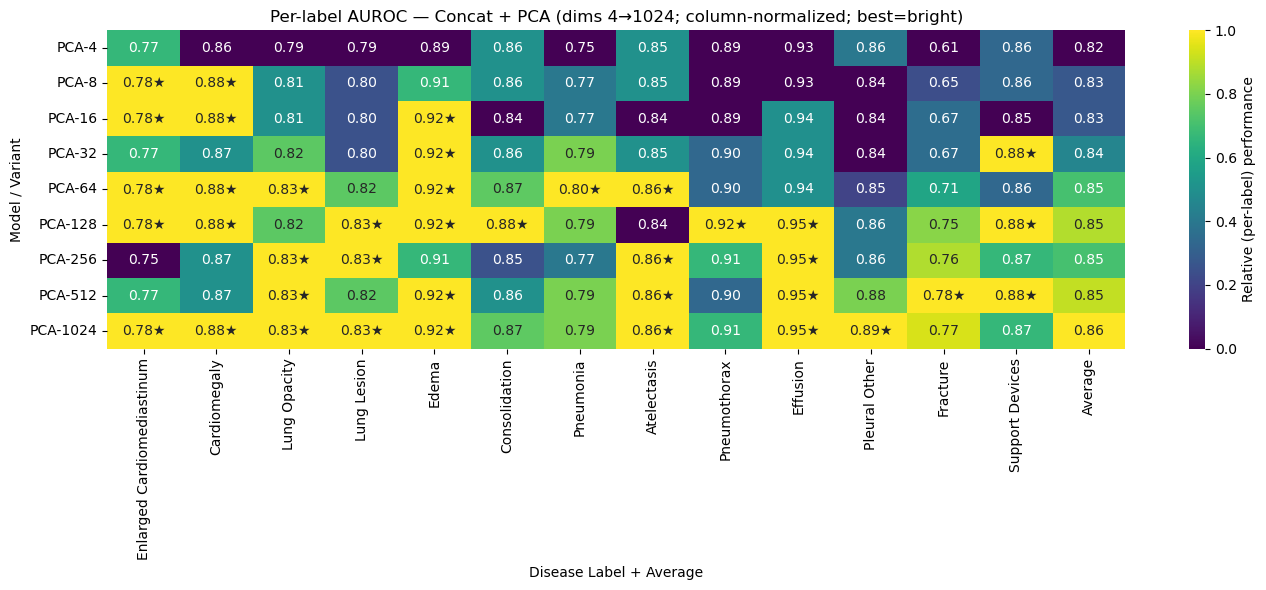

In [9]:
# ==== 1) Ranked heatmap (brightest = best per label) ====
import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from typing import Dict, List

def plot_per_label_heatmap_ranked(
    per_label_results: Dict[str, Dict[str, float]],
    label_cols: List[str],
    title: str = "Per-label AUROC (column-normalized; brightest = best)",
    add_average: bool = True,
    sort_rows_by_avg: bool = True,
):
    # 1) True values in wide DF (preserve your label order)
    df_true = pd.DataFrame(per_label_results).T
    for c in label_cols:
        if c not in df_true.columns:
            df_true[c] = np.nan
    df_true = df_true[label_cols]

    # 2) Average across labels (macro AUROC)
    if add_average:
        df_true["Average"] = df_true[label_cols].mean(axis=1)

    # 3) Optional sort by Average (descending)
    if sort_rows_by_avg and "Average" in df_true.columns:
        df_true = df_true.sort_values("Average", ascending=False)

    # 4) Column-wise normalization for color so max per label = 1 (brightest)
    df_norm = df_true.copy()
    for c in label_cols:
        col = df_norm[c].to_numpy(dtype=float)
        cmin = np.nanmin(col) if np.isfinite(col).any() else np.nan
        cmax = np.nanmax(col) if np.isfinite(col).any() else np.nan
        if np.isfinite(cmin) and np.isfinite(cmax) and cmax > cmin:
            df_norm[c] = (col - cmin) / (cmax - cmin)
        else:
            # constant or all-NaN → neutral mid-gray
            df_norm[c] = 0.5

    # Normalize "Average" across rows (for a meaningful color in that column)
    if "Average" in df_norm.columns:
        av = df_true["Average"].to_numpy(dtype=float)
        if np.isfinite(av).any() and np.nanmax(av) > np.nanmin(av):
            df_norm["Average"] = (av - np.nanmin(av)) / (np.nanmax(av) - np.nanmin(av))
        else:
            df_norm["Average"] = 0.5

    # 5) Annotation strings (real AUROC values), with ★ on per-label winners
    annot_text = df_true.copy().astype(float).applymap(
        lambda v: "" if np.isnan(v) else f"{v:.2f}"
    )
    for c in label_cols:
        col_vals = df_true[c]
        if col_vals.notna().any():
            mx = col_vals.max()
            winners = col_vals.index[col_vals == mx]
            for r in winners:
                annot_text.loc[r, c] = f"{annot_text.loc[r, c]}★"

    # 6) Plot (fmt="" because annot are strings)
    plt.figure(figsize=(14, 6))
    ax = sns.heatmap(
        df_norm,
        annot=annot_text,
        fmt="",
        cmap="viridis",                  # bright yellow-green = high
        vmin=0.0, vmax=1.0,              # fixed 0–1 normalized scale
        cbar_kws={'label': 'Relative (per-label) performance'}
    )
    ax.set_title(title)
    ax.set_xlabel("Disease Label" + (" + Average" if "Average" in df_true.columns else ""))
    ax.set_ylabel("Model / Variant")
    plt.tight_layout()
    plt.show()


# ==== 2) Merge your two PCA runs into one per-label dict ====
import re
from typing import Union

def _dim_from_key(k: Union[str, int]) -> int | None:
    if isinstance(k, int):
        return k
    m = re.search(r'(\d+)$', str(k))
    return int(m.group(1)) if m else None

def merge_pca_perlabel(*dicts: Dict[Union[str,int], Dict[str, float]]) -> Dict[str, Dict[str, float]]:
    """
    Merge multiple per-label dicts into one, normalizing keys to 'PCA-<dim>'.
    """
    out = {}
    for d in dicts:
        for k, v in d.items():
            dim = _dim_from_key(k)
            if dim is None:
                continue
            out[f"PCA-{dim}"] = v
    return out

# Example: ensure these exist in your session or build them manually
# concat_grid_perlabel_small = {...}   # dims 4, 8
# concat_grid_perlabel_large = {...}   # dims 16..1024

all_pca_perlabel = merge_pca_perlabel(concat_grid_perlabel_small, concat_grid_perlabel_large)

# ==== 3) Order rows by numeric PCA dimension (4, 8, 16, ... 1024) ====
def order_perlabel_by_dim(per_label_results: Dict[str, Dict[str, float]]) -> Dict[str, Dict[str, float]]:
    items = list(per_label_results.items())
    items.sort(key=lambda kv: _dim_from_key(kv[0]))  # numeric sort by dim
    return dict(items)

all_pca_perlabel_ordered = order_perlabel_by_dim(all_pca_perlabel)

# ==== 4) Plot combined heatmap ====
plot_per_label_heatmap_ranked(
    all_pca_perlabel_ordered,
    label_cols,
    title="Per-label AUROC — Concat + PCA (dims 4→1024; column-normalized; best=bright)",
    add_average=True,
    sort_rows_by_avg=False,  # keep numeric 4,8,16,... order
)

In [1]:
# # ==== 1) Ranked heatmap (brightest = best per label) ====
# import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
# from typing import Dict, List

# def plot_per_label_heatmap_ranked(
#     per_label_results: Dict[str, Dict[str, float]],
#     label_cols: List[str],
#     title: str = "Per-label AUROC (column-normalized; brightest = best)",
#     add_average: bool = True,
#     sort_rows_by_avg: bool = True,
# ):
#     # 1) True values in wide DF (preserve your label order)
#     df_true = pd.DataFrame(per_label_results).T
#     for c in label_cols:
#         if c not in df_true.columns:
#             df_true[c] = np.nan
#     df_true = df_true[label_cols]

#     # 2) Average across labels (macro AUROC)
#     if add_average:
#         df_true["Average"] = df_true[label_cols].mean(axis=1)

#     # 3) Optional sort by Average (descending)
#     if sort_rows_by_avg and "Average" in df_true.columns:
#         df_true = df_true.sort_values("Average", ascending=False)

#     # 4) Column-wise normalization for color so max per label = 1 (brightest)
#     df_norm = df_true.copy()
#     for c in label_cols:
#         col = df_norm[c].to_numpy(dtype=float)
#         cmin = np.nanmin(col) if np.isfinite(col).any() else np.nan
#         cmax = np.nanmax(col) if np.isfinite(col).any() else np.nan
#         if np.isfinite(cmin) and np.isfinite(cmax) and cmax > cmin:
#             df_norm[c] = (col - cmin) / (cmax - cmin)
#         else:
#             # constant or all-NaN → neutral mid-gray
#             df_norm[c] = 0.5

#     # Normalize "Average" across rows (for a meaningful color in that column)
#     if "Average" in df_norm.columns:
#         av = df_true["Average"].to_numpy(dtype=float)
#         if np.isfinite(av).any() and np.nanmax(av) > np.nanmin(av):
#             df_norm["Average"] = (av - np.nanmin(av)) / (np.nanmax(av) - np.nanmin(av))
#         else:
#             df_norm["Average"] = 0.5

#     # 5) Annotation strings (real AUROC values), with ★ on per-label winners
#     annot_text = df_true.copy().astype(float).applymap(
#         lambda v: "" if np.isnan(v) else f"{v:.2f}"
#     )
#     for c in label_cols:
#         col_vals = df_true[c]
#         if col_vals.notna().any():
#             mx = col_vals.max()
#             winners = col_vals.index[col_vals == mx]
#             for r in winners:
#                 annot_text.loc[r, c] = f"{annot_text.loc[r, c]}★"

#     # 6) Plot (fmt="" because annot are strings)
#     plt.figure(figsize=(14, 12))
#     ax = sns.heatmap(
#         df_norm,
#         annot=annot_text,
#         fmt="",
#         cmap="viridis",                  # bright yellow-green = high
#         vmin=0.0, vmax=1.0,              # fixed 0–1 normalized scale
#         cbar_kws={'label': 'Relative (per-label) performance'}
#     )
#     ax.set_title(title)
#     ax.set_xlabel("Disease Label" + (" + Average" if "Average" in df_true.columns else ""))
#     ax.set_ylabel("Model / Variant")
#     plt.tight_layout()
#     plt.show()


# # ==== 2) Merge your two PCA runs into one per-label dict ====
# import re
# from typing import Union

# def _dim_from_key(k: Union[str, int]) -> int | None:
#     if isinstance(k, int):
#         return k
#     m = re.search(r'(\d+)$', str(k))
#     return int(m.group(1)) if m else None

# def merge_pca_perlabel(*dicts: Dict[Union[str,int], Dict[str, float]]) -> Dict[str, Dict[str, float]]:
#     """
#     Merge multiple per-label dicts into one, normalizing keys to 'PCA-<dim>'.
#     """
#     out = {}
#     for d in dicts:
#         for k, v in d.items():
#             dim = _dim_from_key(k)
#             if dim is None:
#                 continue
#             out[f"PCA-{dim}"] = v
#     return out

# # Example: ensure these exist in your session or build them manually
# # concat_grid_perlabel_small = {...}   # dims 4, 8
# # concat_grid_perlabel_large = {...}   # dims 16..1024

# all_pca_perlabel = merge_pca_perlabel(concat_grid_perlabel_small, concat_grid_perlabel_large)

# # ==== 3) Order rows by numeric PCA dimension (4, 8, 16, ... 1024) ====
# def order_perlabel_by_dim(per_label_results: Dict[str, Dict[str, float]]) -> Dict[str, Dict[str, float]]:
#     items = list(per_label_results.items())
#     items.sort(key=lambda kv: _dim_from_key(kv[0]))  # numeric sort by dim
#     return dict(items)

# all_pca_perlabel_ordered = order_perlabel_by_dim(all_pca_perlabel)

# # ==== 4) Plot combined heatmap ====
# plot_per_label_heatmap_ranked(
#     all_pca_perlabel_ordered,
#     label_cols,
#     title="Per-label AUROC — Concat + PCA (dims 4→1024; column-normalized; best=bright)",
#     add_average=True,
#     sort_rows_by_avg=False,  # keep numeric 4,8,16,... order
# )